# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
project_dir = '/datadisk/whiteboxing/examples'
# project_dir = 'V:\\whiteboxing\\examples' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\exampada'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

In [3]:
datasets = [
            ds.breast,
            ds.cardio,
            ds.diaretino,
            ds.heart,
            ds.mhtech14,
            ds.mh2tech16,
            ds.readmit,
            ds.thyroid,
            dsp.usoc2,
           ]

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.9233
Best parameters:{'max_depth': 32.0, 'n_estimators': 1600, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[11741   329]
 [  707   815]]


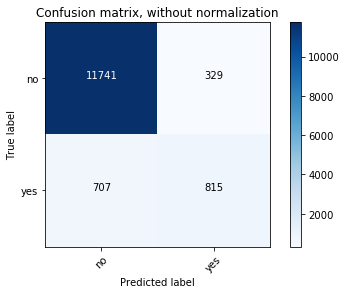

Normalized confusion matrix
[[0.97 0.03]
 [0.46 0.54]]


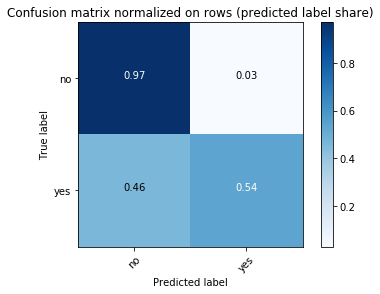

In [4]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.bankmark(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# build model, tuned for high accuracy
model = 'RandomForest'
# model = 'AdaBoost1'
# model = 'AdaBoost2'
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    stop # ValueError

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [5]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
chirps_explanation_async=True

# how many instances to explain in total from a test/unseen set
# doesn't matter if you don't know how large the dataset is
# this function prevents you maxing out, or put n_instances = None for whole dataset
n_instances = rt.n_instance_ceiling(ds_container=tt, n_instances=10)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
tt.current_row_test = 0
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(n_instances, which_split='test') # default

option 2: just run the whole test set

In [6]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [7]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [8]:
# wrapper object needs the decision forest itself and the dataset meta data (we have a convenience function for this)
f_walker = strcts.forest_walker(forest = rf, meta_data=meta_data)

Now the work of extracting all the paths for each instance is done

In [9]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - creates a paths_container (even for just one instance) as a new property
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
f_walker.forest_walk(instances = instances_enc_matrix
                    , labels = preds # we're explaining the prediction, not the true label!
                    , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 10 instances... (please wait)
Forest Walk with async = True
Forest Walk time elapsed: 1.6609 seconds


# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [12]:
chirps_explanation_async=False
# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

# build CHIRPS and a rule for each instance represented in the path detail
CHIRPS = strcts.CHIRPS_container(f_walker.path_detail,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                # sample_labels=tt.y_train,  # any representative sample can be used
                                sample_labels=sample_labels,
                                meta_data=meta_data)

print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.batch_run_CHIRPS(target_classes=preds, # we're explaining the prediction, not the true label!
                        chirps_explanation_async=chirps_explanation_async,
                        random_state=random_state,
                        which_trees=which_trees,
                        alpha_paths=0.0,
                        support_paths=0.1,
                        score_func=1,
                        precis_threshold=0.99,
                        disc_path_bins=4,
                        merging_bootstraps=20,
                        pruning_bootstraps=20,
                        delta=0.09,
                        weighting='kldiv')

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

Running CHIRPS on a batch of 10 instances... (please wait)
Working on CHIRPS for instance 0 of 10
as_chirps for batch_idx 0
start mining for batch_idx 0 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 3 patterns out of 152 by numeric redundancy
found 149 patterns from 1595 for batch_idx 0
start score sort for batch_idx 0 (149) patterns
start merge rule for batch_idx 0 (149) patterns
[('duration', True, 454.89758), ('month_oct', True, 0.5), ('nr.employed', False, 5087.30248)]
0.9801545853352831 0.6545544052747974 0.1601447827081337 0.14801752404044863
merge complete for batch_idx 0 (149) patterns
start get explainer for batch_idx 0
as_chirps for batch_idx 1
start mining for batch_idx 1 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 2 patterns out of 91 by numeric redundancy
found 89 patterns from 1598 for batch_idx 1
start score sort for batch_idx 1 (89) patterns
start merge rule for batch_idx 1 (89) patterns
[('duration', True, 459.47245), ('emp.var.rate', False, 0.22056)]
0.9961365902293121 0.4973908747638791 0.38479442784073165 0.2602655140475456
merge complete for batch_idx 1 (89) patterns
start get explainer for batch_idx 1
as_chirps for batch_idx 2
start mining for batch_idx 2 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


found 245 patterns from 1340 for batch_idx 2
start score sort for batch_idx 2 (245) patterns
start merge rule for batch_idx 2 (245) patterns
[('duration', True, 755.0321), ('emp.var.rate', False, 0.24547)]
0.9785702137309371 0.4974750343948495 0.02265466890106497 0.040127346289049536
merge complete for batch_idx 2 (245) patterns
start get explainer for batch_idx 2
as_chirps for batch_idx 3
start mining for batch_idx 3 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 1 patterns out of 97 by numeric redundancy
found 96 patterns from 1258 for batch_idx 3
start score sort for batch_idx 3 (96) patterns
start merge rule for batch_idx 3 (96) patterns
[('nr.employed', False, 5088.0), ('duration', True, 752.5493)]
0.9580548948540794 0.5755495804111926 0.05615380429172557 0.07714992890620885
merge complete for batch_idx 3 (96) patterns
start get explainer for batch_idx 3
as_chirps for batch_idx 4
start mining for batch_idx 4 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 14 patterns out of 192 by numeric redundancy
found 178 patterns from 1584 for batch_idx 4
start score sort for batch_idx 4 (178) patterns
start merge rule for batch_idx 4 (178) patterns
[('duration', True, 334.46432), ('emp.var.rate', False, -0.47728)]
0.996340073198536 0.5167257350611001 0.19345696950156513 0.15616766980101532
merge complete for batch_idx 4 (178) patterns
start get explainer for batch_idx 4
Working on CHIRPS for instance 5 of 10
as_chirps for batch_idx 5
start mining for batch_idx 5 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans


reduced 1 patterns out of 65 by numeric redundancy
found 64 patterns from 1438 for batch_idx 5
start score sort for batch_idx 5 (64) patterns
start merge rule for batch_idx 5 (64) patterns
[('duration', False, 163.07706), ('euribor3m', True, 0.87226), ('poutcome_success', False, 0.5)]
0.8488063660477454 0.011799836490752436 0.2827660956140392 0.24100078409009912
merge complete for batch_idx 5 (64) patterns
start get explainer for batch_idx 5
as_chirps for batch_idx 6
start mining for batch_idx 6 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 1 patterns out of 144 by numeric redundancy
found 143 patterns from 1595 for batch_idx 6
start score sort for batch_idx 6 (143) patterns
start merge rule for batch_idx 6 (143) patterns
[('duration', True, 462.20822), ('month_oct', True, 0.5), ('nr.employed', False, 5088.43836)]
0.9794594594594594 0.6536633220066914 0.20314257370339042 0.17616699162748026
merge complete for batch_idx 6 (143) patterns
start get explainer for batch_idx 6
as_chirps for batch_idx 7
start mining for batch_idx 7 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


found 178 patterns from 1459 for batch_idx 7
start score sort for batch_idx 7 (178) patterns
start merge rule for batch_idx 7 (178) patterns
[('duration', True, 612.013), ('euribor3m', False, 1.15922)]
0.9622670333027803 0.5974132931864126 0.10435015561564527 0.12490395697272383
merge complete for batch_idx 7 (178) patterns
start get explainer for batch_idx 7
as_chirps for batch_idx 8
start mining for batch_idx 8 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


found 105 patterns from 1600 for batch_idx 8
start score sort for batch_idx 8 (105) patterns
start merge rule for batch_idx 8 (105) patterns
[('duration', True, 537.47989), ('emp.var.rate', False, 0.22065)]
0.993049313919348 0.5093003503432842 0.22285004943975595 0.1543567590348751
merge complete for batch_idx 8 (105) patterns
start get explainer for batch_idx 8
as_chirps for batch_idx 9
start mining for batch_idx 9 with support = 0.1


/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1450: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5) # can result in nans
/home/julianhatwell/Documents/github/explain_te/CHIRPS/structures.py:1445: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5) # can result in nans if no value falls into bin


reduced 1 patterns out of 158 by numeric redundancy
found 157 patterns from 1595 for batch_idx 9
start score sort for batch_idx 9 (157) patterns
start merge rule for batch_idx 9 (157) patterns
[('duration', True, 550.78325), ('nr.employed', False, 5136.94815), ('month_oct', True, 0.5)]
0.9904010792300109 0.5764197629039365 0.3416857315963251 0.2706955122474523
merge complete for batch_idx 9 (157) patterns
start get explainer for batch_idx 9
CHIRPS time elapsed: 245.6034 seconds
CHIRPS with async = False


# Viewing and Evaluating CHIRPS explanations
Evaluation is done using unseen data to see how well the explanations generalise. The data_split_container object (tt) has a  leave-one-out function that is used during the routine to ensure that the datum we are explaining is excluded from the evaluation.

In [13]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

save_results_file = model + '_CHIRPS_rnst_' + str(random_state)

rt.evaluate_CHIRPS_explainers(CHIRPS, tt, labels.index, # for full batch runs: tt.y_test.index,
                              forest=rf,
                              meta_data=meta_data,
                              model=model,
                              eval_start_time=results_start_time,
                              print_to_screen=True, # set True when running single instances
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=save_path,
                              dataset_name='test',
                              save_results_file=save_results_file,
                              save_CHIRPS=False)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

evaluating found explanations

INSTANCE RESULTS
['instance id: 9180 with true class label: 0 (no)']

Model Results for Instance
['target (predicted) class: 0 (no)']
target class prior (training data): 0.887466498502286
forest vote share (unseen instance): 0.996875
forest vote margin (unseen instance): 0.9937499999999999
confidence weighted forest vote share (unseen instance): 0.996875
confidence weighted forest vote margin (unseen instance): 0.9937499999999999

rule: duration <= 454.89758 AND month_oct False AND nr.employed > 5087.30248
rule cardinality: 3
Fraction of total points of rule: 0.1601447827081337
Fraction of total weight of rule: 0.14801752404044863

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.17798587463740698
rule xcoverage (training data): 0.17797465161737813
rule precision (training data): 0.9989369241672572
rule stability (training data): 0.9985833185762352
rule recall (training data): 0.20031265543949406
rule f1 sc

INSTANCE RESULTS
['instance id: 1795 with true class label: 0 (no)']

Model Results for Instance
['target (predicted) class: 0 (no)']
target class prior (training data): 0.887466498502286
forest vote share (unseen instance): 0.8375
forest vote margin (unseen instance): 0.675
confidence weighted forest vote share (unseen instance): 0.8373709753787879
confidence weighted forest vote margin (unseen instance): 0.6747419507575758

rule: duration <= 755.0321 AND emp.var.rate > 0.24547
rule cardinality: 2
Fraction of total points of rule: 0.02265466890106497
Fraction of total weight of rule: 0.040127346289049536

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.1338441165342414
rule xcoverage (training data): 0.1338356769027051
rule precision (training data): 0.989396795475966
rule stability (training data): 0.9889333647280433
rule recall (training data): 0.1491863852767711
rule f1 score (training data): 0.25927755480086445
rule NPV (training d

INSTANCE RESULTS
['instance id: 23918 with true class label: 0 (no)']

Model Results for Instance
['target (predicted) class: 0 (no)']
target class prior (training data): 0.887466498502286
forest vote share (unseen instance): 0.99
forest vote margin (unseen instance): 0.98
confidence weighted forest vote share (unseen instance): 0.9899281655844157
confidence weighted forest vote margin (unseen instance): 0.9798563311688312

rule: duration <= 334.46432 AND emp.var.rate > -0.47728
rule cardinality: 2
Fraction of total points of rule: 0.19345696950156513
Fraction of total weight of rule: 0.15616766980101532

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.2791335603480893
rule xcoverage (training data): 0.2791159593921433
rule precision (training data): 0.9988703117939449
rule stability (training data): 0.9986448334274421
rule recall (training data): 0.31414765863710653
rule f1 score (training data): 0.4779717822585005
rule NPV (training d

INSTANCE RESULTS
['instance id: 44085 with true class label: 0 (no)']

Model Results for Instance
['target (predicted) class: 0 (no)']
target class prior (training data): 0.887466498502286
forest vote share (unseen instance): 0.996875
forest vote margin (unseen instance): 0.9937499999999999
confidence weighted forest vote share (unseen instance): 0.996482683982684
confidence weighted forest vote margin (unseen instance): 0.992965367965368

rule: duration <= 462.20822 AND month_oct False AND nr.employed > 5088.43836
rule cardinality: 3
Fraction of total points of rule: 0.20314257370339042
Fraction of total weight of rule: 0.17616699162748026

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.3488775381510909
rule xcoverage (training data): 0.3488555394413267
rule precision (training data): 0.997469269703543
rule stability (training data): 0.9972892382759555
rule recall (training data): 0.39209834434733176
rule f1 score (training data): 0.5

INSTANCE RESULTS
['instance id: 2632 with true class label: 0 (no)']

Model Results for Instance
['target (predicted) class: 0 (no)']
target class prior (training data): 0.887466498502286
forest vote share (unseen instance): 1.0
forest vote margin (unseen instance): 1.0
confidence weighted forest vote share (unseen instance): 0.9999924698795181
confidence weighted forest vote margin (unseen instance): 0.9999849397590361

rule: duration <= 537.47989 AND emp.var.rate > 0.22065
rule cardinality: 2
Fraction of total points of rule: 0.22285004943975595
Fraction of total weight of rule: 0.1543567590348751

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.10994450750409887
rule xcoverage (training data): 0.10993757487861781
rule precision (training data): 0.9971313826735514
rule stability (training data): 0.9965606190885641
rule recall (training data): 0.12349889860015632
rule f1 score (training data): 0.21977744056651494
rule NPV (training dat